# Trash Classification using EfficentNet



1.   Introduction
2.   Explanatory Data Analysis
3.   Training Model
4.   Evaluation



## 1.Introduction
This notebook use to solve image classification problem using transfer learning using efficientNet. The dataset can be found in [trashnet dataset](https://huggingface.co/datasets/garythung/trashnet). The dataset conduct of 6 type of trash including cardboard, glass, metal, paper, plastic, trash. This notebook also integrate with wandb.ai to evaluate the performance of the model. The pretained model also can be found in hugging face model. This notebook used in google colab!

## 2. Explanatory Data Analysis
In this section we will get knowledge about the dataset


### a. Download the dataset
To download the dataset, we can use git clone to clone the repository of the dataset. The repository consist of original size dataset and resized dataset. In this notebook will perform using original dataset. After cloning the dataset, unzip also needed to extract all the data. Cloning the repository might take several minutes

In [1]:
!git clone https://huggingface.co/datasets/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.97 KiB | 503.00 KiB/s, done.
Filtering content: 100% (2/2), 3.42 GiB | 34.42 MiB/s, done.


In [2]:
!unzip /content/trashnet/dataset-original.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset-original/cardboard/._cardboard132.jpg  
  inflating: dataset-original/cardboard/cardboard133.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard133.jpg  
  inflating: dataset-original/cardboard/cardboard134.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard134.jpg  
  inflating: dataset-original/cardboard/cardboard135.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard135.jpg  
  inflating: dataset-original/cardboard/cardboard136.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard136.jpg  
  inflating: dataset-original/cardboard/cardboard137.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard137.jpg  
  inflating: dataset-original/cardboard/cardboard138.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard138.jpg  
  inflating: dataset-original/cardboard/cardboard139.jpg  
  inflating: __MACOSX/dataset-original/cardboa

### b. Import and install all dependencies


In [3]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
import keras
from PIL import Image
import wandb
from wandb.integration.keras import WandbMetricsLogger,WandbModelCheckpoint

Login to wandb to get authentication for training report

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### b. Visualize Data Distribution
We need to check the data distribution to detect the imbalance of the dataset.

Load all data label from directories

In [6]:
import os
total_data_class = []
base_path = "/content/dataset-original"
all_dir_class = os.listdir(base_path)
all_dir_class



['plastic', 'trash', 'glass', 'metal', 'cardboard', '.DS_Store', 'paper']

remove hidden file

In [7]:
all_dir_class.remove(".DS_Store")

Visualize class distributin

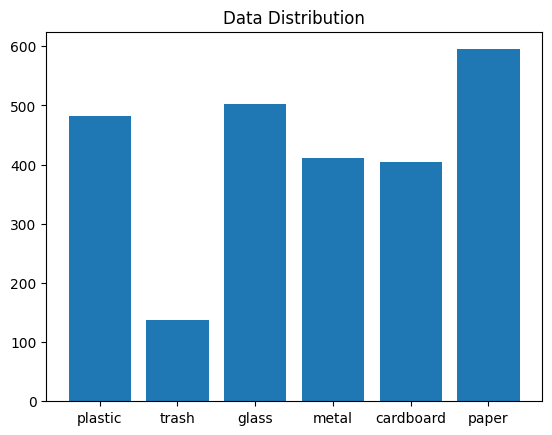

In [8]:
total_data_class = []
for img_data in all_dir_class:
  total_data_class.append(len(os.listdir(os.path.join(base_path,img_data))))

plt.title("Data Distribution")
plt.bar(all_dir_class,total_data_class)
plt.show()


The data seem unbalanced especially in class of thrash. To solve this, using classweight may be an option

Showing 3 images on each classes

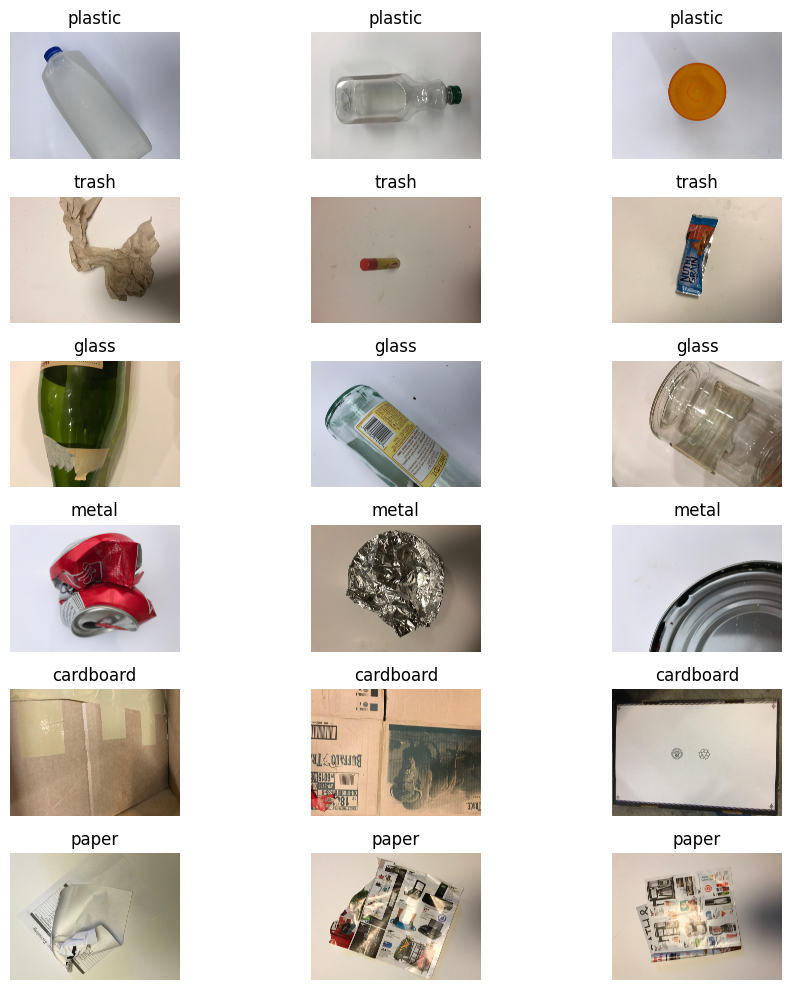

In [9]:
plt.figure(figsize=(10,10))

for class_ind, class_name in enumerate(all_dir_class):
  images_path = os.path.join(base_path,class_name)
  images = os.listdir(images_path)
  for i in range(3):
    ax= plt.subplot(len(all_dir_class),3,class_ind*3+i+1)
    img = Image.open(os.path.join(images_path,images[i]))
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

### b. Loading the dataset
The dataset loaded using tensorflow dataset. The dataset split to 80:20 for each training and validation. Dataset also performed with augmented to increase the number of the data. TF Autotune also perform to increase the performance during the training

In [10]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = ("/content/dataset-original")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Configure the datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


The dataset is small for training full CNN from strach

In [11]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# 3. Building the model

The model using transfer learning on efficientNet. The output layer customized to perform classification on trash dataset. The model will train without and using class weight. The configuration declared for wandb monitoring


In [12]:
wandb.init(
    # set the wandb project where this run will be logged
    project="trash_classification",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout_1": 0.2,
        "layer_2": 6,
        "activation_2": "softmax",
        "optimizer": "adam",
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 5,
        "batch_size": 64
    }
)
config = wandb.config
# Building Model

batch_size = 64
num_epochs = 10
image_height, image_width = 180, 180  # Adjust according to your image size


# Load EfficientNetB0 model pre-trained on ImageNet, excluding top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Freeze the base model
base_model.trainable = False


# Define the CNN model
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(config.layer_1,activation= config.activation_1),
    keras.layers.Dropout(config.dropout_1),
    keras.layers.Dense(config.layer_2, activation=config.activation_2)
])

model2 = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(config.layer_1,activation= config.activation_1),
    keras.layers.Dropout(config.dropout_1),
    keras.layers.Dense(config.layer_2, activation=config.activation_2)
])



wandb: Currently logged in as: fadhilelrizandamicr (fe-org). Use `wandb login --relogin` to force relogin


16705208/16705208 [==============================] - 0s 0us/step


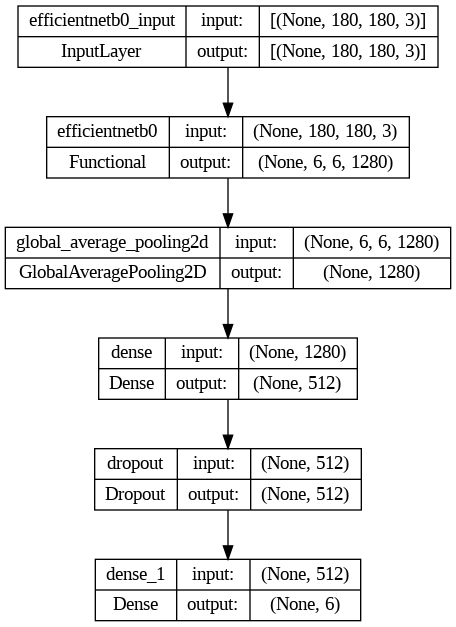

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 6, 6, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 4708521 (17.96 MB)
Trainable params: 658

In [15]:
# Compile the model
model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])



In [16]:
    wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
    ]



Training model without class weight


In [18]:
history = model.fit(augmented_train_ds,
                    epochs=config.epoch,validation_data = val_ds,
                    callbacks=wandb_callbacks,
                    batch_size=config.batch_size,
                    )

Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7532

wandb: Adding directory to artifact (./my_model_01)... Done. 0.2s


64/64 [==============================] - 371s 5s/step - loss: 0.6907 - accuracy: 0.7532 - val_loss: 0.4351 - val_accuracy: 0.8475
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8699

wandb: Adding directory to artifact (./my_model_02)... Done. 0.2s


64/64 [==============================] - 354s 5s/step - loss: 0.3696 - accuracy: 0.8699 - val_loss: 0.4000 - val_accuracy: 0.8257
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.9026

wandb: Adding directory to artifact (./my_model_03)... Done. 0.1s


64/64 [==============================] - 331s 5s/step - loss: 0.2661 - accuracy: 0.9026 - val_loss: 0.3781 - val_accuracy: 0.8455
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9224

wandb: Adding directory to artifact (./my_model_04)... Done. 0.2s


64/64 [==============================] - 367s 5s/step - loss: 0.2185 - accuracy: 0.9224 - val_loss: 0.4121 - val_accuracy: 0.8297
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9347

wandb: Adding directory to artifact (./my_model_05)... Done. 0.1s


64/64 [==============================] - 358s 5s/step - loss: 0.1838 - accuracy: 0.9347 - val_loss: 0.3990 - val_accuracy: 0.8495


Training model with class weight

In [19]:
# Compile the model
model2.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])



In [20]:
# Step 1: Extract Class Distribution
class_names = train_ds.class_names
label_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds.unbatch():
    label_counts[class_names[labels.numpy()]]+=1


# Step 2: Compute Class Weights
total_samples = sum(label_counts.values())
class_weights = {i: total_samples / (len(class_names) * count) for i, count in enumerate(label_counts.values())}


In [21]:
history2 = model2.fit(augmented_train_ds,
                    epochs=config.epoch,validation_data = val_ds,
                    callbacks=wandb_callbacks,
                    batch_size=config.batch_size,
                    class_weight=class_weights)

Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.7305

wandb: Adding directory to artifact (./my_model_01)... Done. 0.1s


64/64 [==============================] - 371s 5s/step - loss: 0.7866 - accuracy: 0.7305 - val_loss: 0.5065 - val_accuracy: 0.8317
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8571

wandb: Adding directory to artifact (./my_model_02)... Done. 0.1s


64/64 [==============================] - 330s 5s/step - loss: 0.3957 - accuracy: 0.8571 - val_loss: 0.4218 - val_accuracy: 0.8436
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8843

wandb: Adding directory to artifact (./my_model_03)... Done. 0.1s


64/64 [==============================] - 359s 5s/step - loss: 0.3114 - accuracy: 0.8843 - val_loss: 0.4232 - val_accuracy: 0.8317
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9169

wandb: Adding directory to artifact (./my_model_04)... Done. 0.1s


64/64 [==============================] - 367s 5s/step - loss: 0.2465 - accuracy: 0.9169 - val_loss: 0.4169 - val_accuracy: 0.8594
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9263

wandb: Adding directory to artifact (./my_model_05)... Done. 0.2s


64/64 [==============================] - 368s 6s/step - loss: 0.1967 - accuracy: 0.9263 - val_loss: 0.3859 - val_accuracy: 0.8634


In [22]:
 wandb.finish()

epoch/accuracy,▂▆▇██▁▅▆▇█
epoch/epoch,▁▃▅▆█▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,▇▃▂▁▁█▃▂▂▁
epoch/val_accuracy,▅▁▅▂▅▂▄▂▇█
epoch/val_loss,▄▂▁▃▂█▃▃▃▁
epoch/accuracy,0.92631
epoch/epoch,4
epoch/learning_rate,0.001
epoch/loss,0.19666
epoch/val_accuracy,0.86337


# 4. Evaluation

Visualize the performance (model 1)

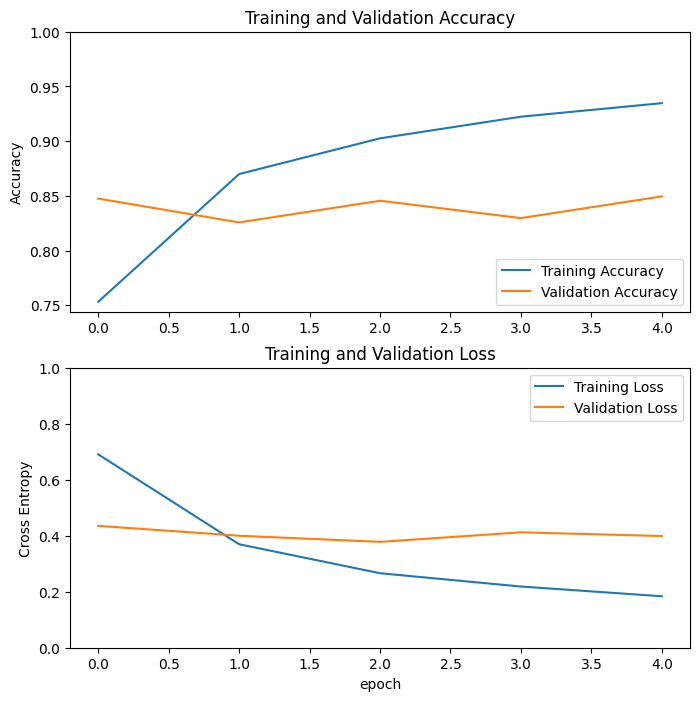

In [23]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



Visualize performance (model 2)

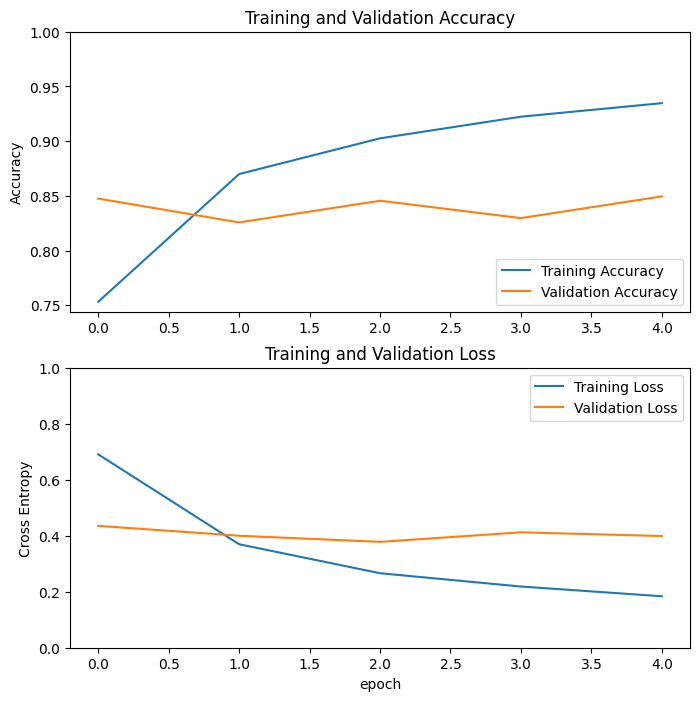

In [24]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to get predictions from a dataset
def get_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_labels)
    return np.array(y_true), np.array(y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()




Visualize Confusion Matrix Model 1

1/1 [==============================] - 4s 4s/step


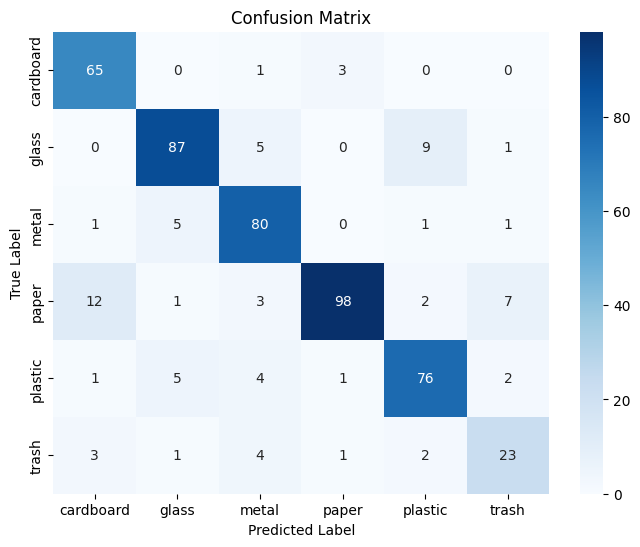

In [26]:
# Get predictions for augmented validation dataset
y_true, y_pred = get_predictions(model, val_ds)
plot_confusion_matrix(y_true, y_pred, class_names)

Visualize confusion matrix model 2

1/1 [==============================] - 3s 3s/step


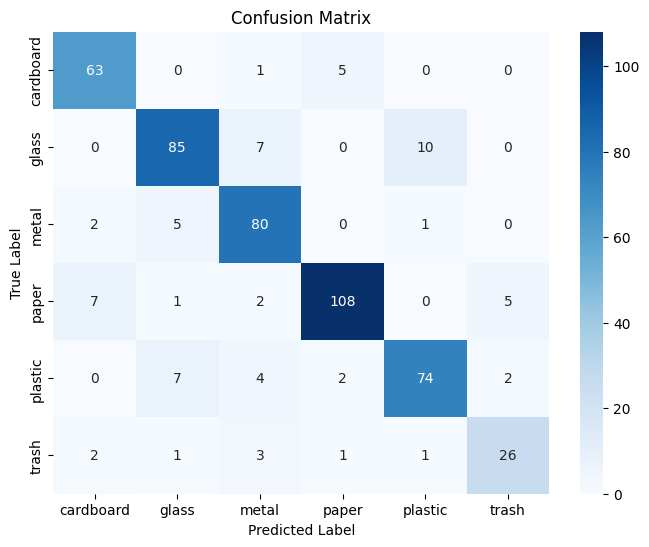

In [27]:
# Get predictions for augmented validation dataset
y_true, y_pred = get_predictions(model2, val_ds)
plot_confusion_matrix(y_true, y_pred, class_names)

# Additional

Send Model to hugging face using hugging_hub

In [28]:
from huggingface_hub import login
login()

In [29]:
model.save("Model_1")
model2.save("Model_2")

In [30]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path="/content/Model_1",
    repo_id="fadhilelrizanda/trashimgclassification-efficientNet",
    repo_type="model",
)

from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path="/content/Model_2",
    repo_id="fadhilelrizanda/trashimgclassification-efficientNet",
    repo_type="model",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-6650b8f2-53d8b8e359044d4a6dd4393c;284d7573-1695-444f-8f2f-fadcd431379e)

Repository Not Found for url: https://huggingface.co/api/models/fadhilelrizanda/trashimgclassification-efficientNet/preupload/main.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.
Note: Creating a commit assumes that the repo already exists on the Huggingface Hub. Please use `create_repo` if it's not the case.